# Import packages

In [1]:
%matplotlib inline

In [2]:
# system
import os
import sys

# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# reading .bmp files - failed
from scipy import misc

# skimage
from skimage import io
from skimage import filters

In [3]:
# custom imports
from custom_metrics import dice_coef, dice_coef_multilabel

# Load Images and Masks

In [4]:
FOLDER_PATH = '../data/normal_columnar'

In [5]:
# file names: all, images, masks

file_names = sorted(os.listdir(FOLDER_PATH))
img_names = sorted([s for s in file_names if '-d' not in s])
mask_names = sorted([s for s in file_names if '-d' in s ])

# no intersection there
assert len( set(mask_names).intersection(set(img_names)) ) == 0

In [6]:
# patient ids (indexes)
idxs = sorted([name.split('.')[0] for name in img_names])

# Iterative file-reading in pairs

In [7]:
#print('Image Shape', ' '*(15 - len('Image Shape')), '| Mask Shape')
#print(30 * '-')

for idx in idxs:
    
    # make indexes into file names
    img_name = idx + '.BMP'
    mask_name = idx + '-d.bmp'
    
    # read off a pair
    img = io.imread(os.path.join(FOLDER_PATH, img_name))
    mask = io.imread(os.path.join(FOLDER_PATH, mask_name))[:, :, 2]
    
    # check the shape correspondance
    assert img.shape[:2] == mask.shape[:2]
    
    # print shapes
    # print(img.shape, ' '*(15 - len(str(img.shape))), '|', mask.shape)

# Read an Image/Mask pair

In [8]:
idx1 = '153956040-153956058-001'

# make indexes into file names
img_name = idx1 + '.BMP'
mask_name = idx1 + '-d.bmp'

img1 = io.imread(os.path.join(FOLDER_PATH, img_name))
mask1 = io.imread(os.path.join(FOLDER_PATH, mask_name))[:, :, 2]

mask1[mask1 == 0] = 0
mask1[mask1 == 128] = 1
mask1[mask1 == 255] = 2

# Work with image in gray scale now

In [9]:
gray1 = img1.mean(-1)

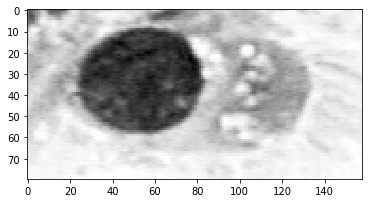

In [10]:
plt.imshow(gray1, cmap='gray')

**Median filter can help to reduce noise.**

In [11]:
gray1.shape

(80, 158)

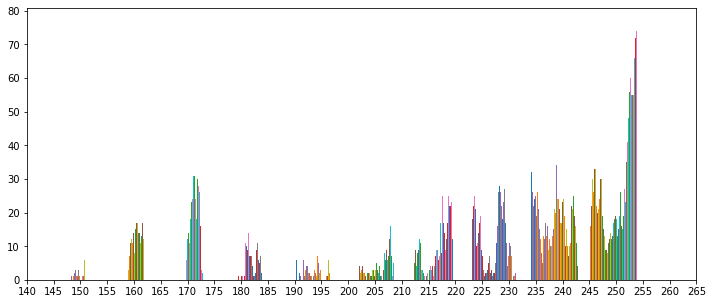

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(gray1)

ax.set_xticks(range(140, 270, 5))
fig.show()

# Methods from Lecture 1

## Desired Output

Channel 2 (chose to sork with it)


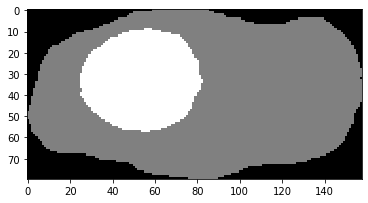

In [13]:
print('Channel 2 (chose to sork with it)')
plt.imshow(mask1, cmap='gray')
plt.show()

### Assign binary masks for the 3 labels

In [14]:
nucleus = (mask1 == 2)
cytoplasm = (mask1 == 1)
background = (mask1 == 0)

Black Nucleus


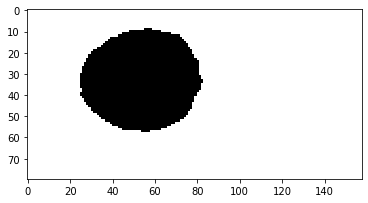

In [15]:
print('Black Nucleus')
plt.imshow(~nucleus, cmap='gray')
plt.show()

Black Cytoplasm


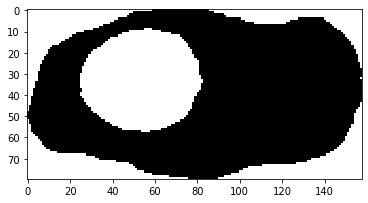

In [16]:
print('Black Cytoplasm')
plt.imshow(~cytoplasm, cmap='gray')
plt.show()

Black Background


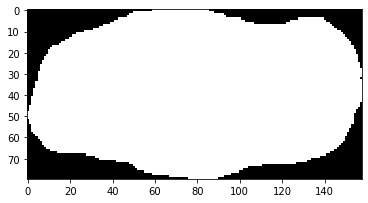

In [17]:
print('Black Background')
plt.imshow(~background, cmap='gray')
plt.show()

## Manual thresholding

### Nucleus

In [18]:
threshold1 = 200
print(threshold1) 
nucleus_pred = (gray1 <= threshold1)

200


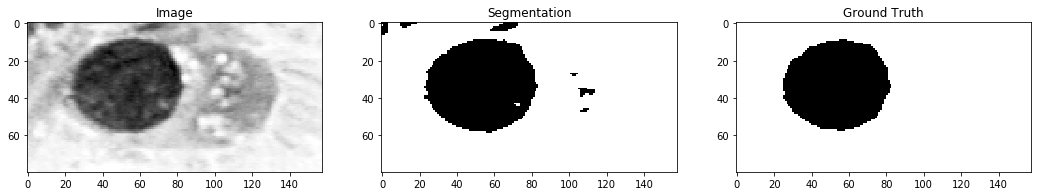

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(gray1, cmap='gray')
ax1.set_title('Image')

ax2.imshow(~nucleus_pred, cmap='gray')
ax2.set_title('Segmentation')

ax3.imshow(~nucleus, cmap='gray')
ax3.set_title('Ground Truth')

plt.show()

In [20]:
dice_coef(nucleus_pred, nucleus)

0.9372549033277798

### Cytoplasm

In [21]:
threshold2 = 245
print(threshold2) 
cytoplasm_pred = np.logical_and((threshold1 <= gray1), (gray1 <= threshold2))

245


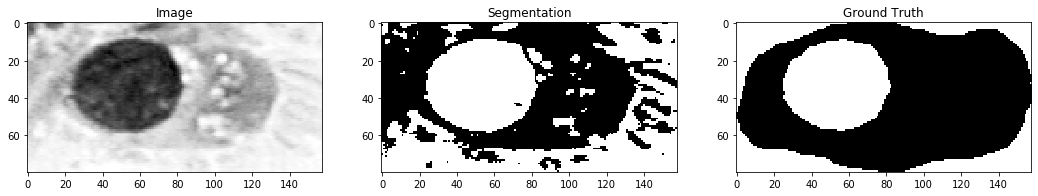

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(gray1, cmap='gray')
ax1.set_title('Image')

ax2.imshow(~cytoplasm_pred, cmap='gray')
ax2.set_title('Segmentation')

ax3.imshow(~cytoplasm, cmap='gray')
ax3.set_title('Ground Truth')

plt.show()

In [23]:
dice_coef(cytoplasm_pred, cytoplasm)

0.742979331839064

### Background

In [24]:
background_pred = (threshold2 < gray1)

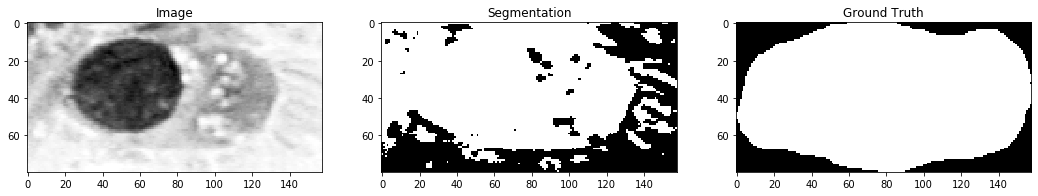

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(gray1, cmap='gray')
ax1.set_title('Image')

ax2.imshow(~background_pred, cmap='gray')
ax2.set_title('Segmentation')

ax3.imshow(~background, cmap='gray')
ax3.set_title('Ground Truth')

plt.show()

In [26]:
dice_coef(background_pred, background)

0.48823618330232005

## All together

In [27]:
numeric1 = np.array((gray1 <= threshold1), dtype=np.float)
numeric2 = np.array((gray1 <= threshold2), dtype=np.float)

avg_mask1_pred = (numeric1 + numeric2)

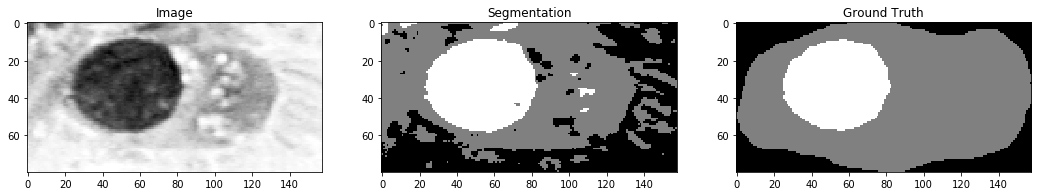

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(gray1, cmap='gray')
ax1.set_title('Image')

ax2.imshow(avg_mask1_pred, cmap='gray')
ax2.set_title('Segmentation')

ax3.imshow(mask1, cmap='gray')
ax3.set_title('Ground Truth')

plt.show()

**Closing might help.**

# Convert into a format for assessing the performance

In [29]:
mask1_channeled = np.stack([nucleus, cytoplasm, background], axis=-1)
mask1_channeled = np.expand_dims(mask1_channeled, axis=0)

mask1_pred_channeled = np.stack([nucleus_pred, cytoplasm_pred, background_pred], axis=-1)
mask1_pred_channeled = np.expand_dims(mask1_pred_channeled, axis=0)

In [30]:
# check dimentions (should be): (batch/index of image, height, width, class_map)
mask1_channeled.shape, mask1_pred_channeled.shape

((1, 80, 158, 3), (1, 80, 158, 3))

In [31]:
dice_coef_multilabel(y_true=mask1_channeled, y_pred=mask1_pred_channeled, numLabels=3)

array([0.9372549 , 0.74297933, 0.48823618])

# Try the same thresholds on multiple images

In [32]:
# Read off images and masks

imgs_list = []
masks_list = []

for idx in idxs:
    
    # make indexes into file names
    img_name = idx + '.BMP'
    mask_name = idx + '-d.bmp'
    
    # read off a pair (only second channel is informative for a mask)
    img = io.imread(os.path.join(FOLDER_PATH, img_name))
    mask = io.imread(os.path.join(FOLDER_PATH, mask_name))[:, :, 2]
    
    
    # change values - needed for k-means later
    mask[mask == 0] = 0
    mask[mask == 128] = 1
    mask[mask == 255] = 2
    
    # check the shape correspondance
    assert img.shape[:2] == mask.shape[:2]
    
    imgs_list.append(img)
    masks_list.append(mask)
    
print(len(imgs_list), len(masks_list))

98 98


In [33]:
# preprocess:
#     - list of images to gray scale
#     - list of masks into 3*hight*width arrays

# store as lists since the dimentions of images and masks vary, so we can't store them in np.arrays

# images
gray_list = []
for i in range(len(imgs_list)):
    img = imgs_list[i]
    # avarage to gray-scale
    img = img.mean(-1)
    gray_list.append(img)
    

# masks
masks_3channels_list = []
for i in range(len(masks_list)):
    mask = masks_list[i]
    
    # avarage to gray-scale
    nucleus = (mask == 2)
    cytoplasm = (mask == 1)
    background = (mask == 0)
    
    mask_channeled = np.stack([nucleus, cytoplasm, background], axis=-1)
    mask_channeled = np.expand_dims(mask_channeled, axis=0) # need to use the multilabel dice score function
    
    masks_3channels_list.append(mask_channeled)
    
print(len(masks_3channels_list))
print(masks_3channels_list[0].shape)

98
(1, 80, 158, 3)


In [34]:
# segment images with manual threshholds

threshold1 = 200
threshold2 = 245
seg_3channels_list = []


for gray_img in gray_list:

    nucleus_pred = (gray_img <= threshold1)
    cytoplasm_pred = np.logical_and((threshold1 <= gray_img), (gray_img <= threshold2))
    background_pred = (threshold2 < gray_img)
    
    seg_channeled = np.stack([nucleus_pred, cytoplasm_pred, background_pred], axis=-1)
    seg_channeled = np.expand_dims(seg_channeled, axis=0) # need to use the multilabel dice score function
    
    seg_3channels_list.append(seg_channeled)
    
print(len(seg_3channels_list))
print(seg_3channels_list[0].shape)

98
(1, 80, 158, 3)


In [35]:
# nucleus, cytoplasm, background
dice_coef_multilabel(y_true=masks_3channels_list[0], y_pred=seg_3channels_list[0], numLabels=3)

array([0.9372549 , 0.74297933, 0.48823618])

In [36]:
dice_scores_all_list = []
for i in range(len(idxs)):
    scores = dice_coef_multilabel(y_true=masks_3channels_list[i], y_pred=seg_3channels_list[i], numLabels=3)
    dice_scores_all_list.append(scores)

In [37]:
dice_scores_all_np = np.array(dice_scores_all_list)

In [38]:
dice_scores_all_np.shape

(98, 3)

In [39]:
dice_scores_all_np.mean(axis=0).round(2)

array([0.4 , 0.17, 0.09])

In [40]:
dice_scores_all_np.min(axis=0).round(3)

array([0.125, 0.   , 0.   ])

In [41]:
dice_scores_all_np.max(axis=0).round(3)

array([0.937, 0.743, 0.61 ])

**Very poor performance with manually selected thresholds on one random image.**

In [42]:
dice_scores_all_np[0].round(2)

array([0.94, 0.74, 0.49])

**Much better performance since we manually selected the thresholds**